<a href="https://colab.research.google.com/github/Kravty/MachineLearning/blob/main/PyTorch_Recommender_MovieLens_20M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3> This notebook contains the Recommender Model (using PyTorch) on MovieLens 20M dataset (20 million ratings and 465,000 tag applications applied to 27,000 movies by 138,000 users. Includes tag genome data with 12 million relevance scores across 1,100 tags). 
<h3> At the end of the notebook, the model produces predictions - recommendations for particular user.

<h4> Import of libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import shuffle

<h4> Data Preparation

In [2]:
# Downloading the data
!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip

File ‘ml-20m.zip’ already there; not retrieving.



In [3]:
!unzip -n ml-20m.zip
!ls

Archive:  ml-20m.zip
ml-20m	ml-20m.zip  sample_data


In [4]:
# Displaying first 5 rows of the csv file using pandas
df = pd.read_csv('ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [5]:
# Adding own numeration of userId to start from 0
df.userId = pd.Categorical(df.userId)
# Saving new IDs
df['new_user_id'] = df.userId.cat.codes

# Adding own numeration of movieId to start from 0
df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [6]:
# Getting user IDs, movie IDs and ratings as separate arrays
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
# Additionally standardizing ratings (center the data; min = -2.5, max = 2.5)
ratings = df['rating'].values - 2.5

In [7]:
# Getting number of users and number of movies
N = len(set(user_ids))
M = len(set(movie_ids))

# Setting embedding dimension
D = 10

<h4> Buidling the model

In [8]:
class Model(nn.Module):
  def __init__(self, n_users, n_items, embed_dim, n_hidden=1024):
    super(Model, self).__init__()
    self.N = n_users
    self.M = n_items
    self.D = embed_dim

    # Custom Model is necessary because there are multiple inputs that Sequential won't handle
    self.u_emb = nn.Embedding(self.N, self.D)
    self.m_emb = nn.Embedding(self.M, self.D)
    self.fc1 = nn.Linear(2 * self.D, n_hidden)
    # One output because scalar regression output is a target
    self.fc2 = nn.Linear(n_hidden, 1)

    # The initialized by PyTorch weights are N(0, 1) which leads to poor results
    # Inspiring TensorFlow weights initialization we can manually change the weights
    self.u_emb.weight.data = nn.Parameter(
        torch.Tensor(np.random.randn(self.N, self.D) *0.01)
    )
    self.m_emb.weight.data = nn.Parameter(
        torch.Tensor(np.random.randn(self.M, self.D) * 0.01)
    )

  def forward(self, u, m):
      u = self.u_emb(u) # Output has shape (n_samples x D)
      m = self.m_emb(m) # Output has shape (n_samples x D)

      # Concatenating both inputs
      out = torch.cat((u, m), 1) # output is (num_samples, 2D)

      out = self.fc1(out)
      out = F.relu(out)
      out = self.fc2(out)
      return out

    

In [9]:
# Creating device object
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
# Moving the model to GPU
model = Model(N, M, D)
model.to(device)

Model(
  (u_emb): Embedding(138493, 10)
  (m_emb): Embedding(26744, 10)
  (fc1): Linear(in_features=20, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)

In [11]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

<h4> Training the model

In [12]:
# Training loop (much faster training than by using build-in datasets and data loaders)
def batch_gd(model, criterion, optimizer, train_data, test_data, epochs, bs=512):
  train_users, train_movies, train_ratings = train_data
  test_users, test_movies, test_ratings = test_data

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  # Calculating batches per epoch
  Ntrain = len(train_users)
  # The result of division can be not an integer so we take ceiling (rounded up)
  batches_per_epoch = int(np.ceil(Ntrain / bs))

  for it in range(epochs):
    t0 = datetime.now()
    # Variable for storing train losses
    train_loss = []

    # Shuffle (from sklearn library) each batch
    train_users, train_movies, train_ratings = shuffle(
        train_users, train_movies, train_ratings
    )

    for j in range(batches_per_epoch):
      # Getting one batch
      users = train_users[j*bs:(j+1)*bs]
      movies = train_movies[j*bs:(j+1)*bs]
      targets = train_ratings[j*bs:(j+1)*bs]

      # Converting to tensors
      users = torch.from_numpy(users).long()
      movies = torch.from_numpy(movies).long()
      targets = torch.from_numpy(targets)
    
      # Reshaping targets
      targets = targets.view(-1, 1).float()

      # Moving the data to GPU
      users, movies, targets = users.to(device), movies.to(device), targets.to(device)

      # Zero the gradients accumulated by PyTorch
      optimizer.zero_grad()

      # Forward pass
      outputs = model(users, movies)
      loss = criterion(outputs, targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      # Appending the loss to list of losses per iteration/batch
      train_loss.append(loss.item())

    # Taking mean value of previous losses as loss per epoch
    train_loss = np.mean(train_loss)
    
    
    # Variable for storing test losses
    test_loss = []
    for j in range(int(np.ceil(len(test_users) / bs))):
      # Getting one batch
      users = test_users[j*bs:(j+1)*bs]
      movies = test_movies[j*bs:(j+1)*bs]
      targets = test_ratings[j*bs:(j+1)*bs]

      # Converting to tensors
      users = torch.from_numpy(users).long()
      movies = torch.from_numpy(movies).long()
      targets = torch.from_numpy(targets)
    
      # Reshaping targets
      targets = targets.view(-1, 1).float()

      # Moving the data to GPU
      users, movies, targets = users.to(device), movies.to(device), targets.to(device)

      outputs = model(users, movies)
      loss = criterion(outputs, targets).item()

      # Appending the loss to list of losses per iteration/batch
      test_loss.append(loss)
    
    # Taking mean value of previous losses as loss per epoch
    test_loss = np.mean(test_loss)

    # Saving the losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    # Calculating training time per epoch
    dt = datetime.now() - t0
    
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, '
          f'Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [13]:
# Shuffle the data to randomize train/test split
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)

In [14]:
# Splitting the data to train set and validation set
Ntrain = int(0.8 * len(ratings))

train_users = user_ids[:Ntrain]
train_movies = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_users = user_ids[Ntrain:]
test_movies = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

In [15]:
# Calling training function
train_losses, test_losses = batch_gd(
    model,
    criterion,
    optimizer,
    (train_users, train_movies, train_ratings),
    (test_users, test_movies, test_ratings), 
    epochs=10)

Epoch 1/10, Train Loss: 0.7254, Test Loss: 0.6816, Duration: 0:01:07.154630
Epoch 2/10, Train Loss: 0.6530, Test Loss: 0.6518, Duration: 0:01:07.476709
Epoch 3/10, Train Loss: 0.6191, Test Loss: 0.6389, Duration: 0:01:06.772010
Epoch 4/10, Train Loss: 0.5982, Test Loss: 0.6355, Duration: 0:01:06.880290
Epoch 5/10, Train Loss: 0.5843, Test Loss: 0.6302, Duration: 0:01:06.670528
Epoch 6/10, Train Loss: 0.5745, Test Loss: 0.6269, Duration: 0:01:06.281677
Epoch 7/10, Train Loss: 0.5674, Test Loss: 0.6274, Duration: 0:01:06.549647
Epoch 8/10, Train Loss: 0.5621, Test Loss: 0.6251, Duration: 0:01:06.020234
Epoch 9/10, Train Loss: 0.5578, Test Loss: 0.6238, Duration: 0:01:05.637986
Epoch 10/10, Train Loss: 0.5544, Test Loss: 0.6260, Duration: 0:01:05.212275


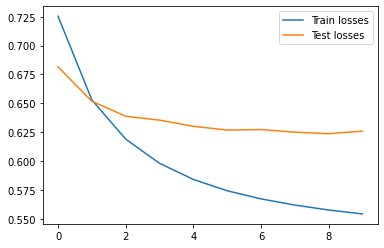

In [16]:
plt.plot(train_losses, label='Train losses')
plt.plot(test_losses, label='Test losses')
plt.legend()
plt.show();

<h4> Making predictions

In [17]:
# Assuming that recommendations will be made for user_id = 1
# Saving already watched movies
watched_movie_ids = df[df.new_user_id == 1].new_movie_id.values
print(f"Already watched movie IDs are: {watched_movie_ids}")

Already watched movie IDs are: [   2   61   69  108  239  257  263  465  476  537  583  874  891  907
 1098 1171 1184 1188 1221 1231 1242 1298 1326 1494 1528 1616 1684 1881
 1885 1886 1887 1888 1889 1890 1902 2206 2369 2370 2705 2772 2862 2865
 3063 3072 3086 3361 3423 3443 3464 3474 3612 3662 3824 3825 3830 3833
 3834 3835 3837 3843 3865]


In [18]:
# By "~" before ".isin" function we get movie IDs that are not watched
# .unique function is used because multiple users could have watch the same movies 
potential_movie_ids = df[~df.new_movie_id.isin(watched_movie_ids)].new_movie_id.unique()
print(f"Shape of potential_movie_ids is {potential_movie_ids.shape}")

Shape of potential_movie_ids is (26683,)


In [19]:
# Repeatting the user ID by the number of not watched movies
user_id_to_recommend = np.ones_like(potential_movie_ids)

In [20]:
# Converting to tensors
t_user_ids = torch.from_numpy(user_id_to_recommend).long().to(device)
t_movie_ids = torch.from_numpy(potential_movie_ids).long().to(device)

In [21]:
# Getting predictions
with torch.no_grad():
  predictions = model(t_user_ids, t_movie_ids)

In [22]:
# Convertting predictions back to NumPy
predictions_np = predictions.cpu().numpy().flatten()

# Sorting indexes in descending order
sort_idx = np.argsort(-predictions_np)

In [23]:
# Printing top 10 predictions
top_10_movie_ids = potential_movie_ids[sort_idx[:10]]
top_10_scores = predictions_np[sort_idx[:10]]

for movie, score in zip(top_10_movie_ids, top_10_scores):
  print("movie:", movie, "score:", score)

movie: 18634 score: 2.6638746
movie: 17466 score: 2.6505167
movie: 9083 score: 2.602747
movie: 4897 score: 2.5932777
movie: 7041 score: 2.5801623
movie: 23381 score: 2.5457282
movie: 5519 score: 2.5452924
movie: 5853 score: 2.5438712
movie: 1263 score: 2.5381198
movie: 10591 score: 2.5203006
